# Convolutional Neural Networks
Convolutional Neural Networks (often abbreviated in CNNs) are a type of deep neural network typically used in the field of Computer Vision, for tasks such as image classification and recognition.

CNNs regard the images as a set of *n* matrices of pixel values, and each of such matrices are fed to one of the *input channels*.

Typically black and white images can be represented with a single matrix representing the level of black of each pixel of the image:

![image](img/lincoln.png)
![image](https://drive.google.com/uc?id=1FS43VEkmLdSdE2p5s8ZJ-G3y5eptI1H4)

For colored images in the RGB (Red, Green, Blue) color space each image has to be instead represented with 3 matrices of pixel values, one for each of the channels of the image:

![image](img/toucan.png)
![image](https://drive.google.com/uc?id=1YxB7GMxCLMNGRGJnytcojebBNkm1R_hG)

Images represented with the HSV (Hue, Saturation, Value) color space require too a CNN with 3 input channels, while images represented with the CMYK (Cyan, Magenta, Yellow, blacK) color space require a CNN with 4 input channels.



## Convolutions

CNN can successfully capture the Spatial and Temporal dependencies in an image through the application on the image of an operation called **convolution**; the element involved in carrying out the convolution operation in the kernel, also called filter. The application of a kernel allows the CNN to reduce the input images into a form which is easier to process, without losing features which are critical for getting a good classification of the image itself.

The kernel is tipically defined by two parameters: the *kernel_size*, which specifies the dimension of the convolving kernel matrix, and the *stride*, which specifies the number of columns the kernel matrix should move after each convolution. In the image below a kernel with kernel_size=[3,3] (in yellow) and with values [[1, 0, 1], [0, 1,  0], [1, 0, 1]] is applied with a stride=1 on an image with dimension [5,5,1] (rows, columns, depth).

![image](img/kernel.gif)
![image](https://drive.google.com/uc?id=102P6bAD9myM0_OwcWRfWa5hIzgl8Gkso)

The kernel "slides" over the matrix representing the input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

Now, let's try applying a neural architecture based on CNNs for the task of image classification.  

# The CIFAR-10 Dataset
The dataset which we'll use in this example is CIFAR-10 (Canadian Institute For Advanced Research), which contains 60000 color images of 32x32 pixels in 10 different classes: planes, cars, birds, cats, deers, dogs, frogs, horses, ships, and trucks. The objective of our architecture will be to learn how to distinguish the images belonging to the various classes, thus applying such knowledge to classify the images of the testing set.

The first step is to import CIFAR10 from the pytorch library containing data and utilities for tasks of Computer Vision, named torchvision.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transformation needed to transform the input images in Tensors
# with values in a normalized range of [-1, 1].
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), #
                                                     (0.5, 0.5, 0.5))])

# Loading the training section of CIFAR10 (train=True) in a DataLoader; the
# images will be transformed with the previously specified command
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Loading the testing section of CIFAR10 (train=False) in a DataLoader; the
# images will be transformed with the previously specified command
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

ModuleNotFoundError: No module named 'torch'

Now, let's display some of the images of the training set at random:

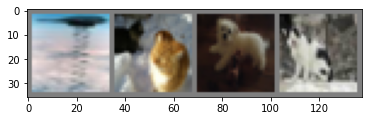

plane   cat   dog   cat


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# The classes of the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

# Function needed to show an image
def imshow(img):

    # Reverting the normalization of the image in order to display it correctly
    img = img / 2 + 0.5

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterable used to get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Showing four randomly selected images and printing their labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Image classification architecture

Let's now specify the neural architecture we want to use to classify the images in the testing set, which image can be seen below.

![image](https://drive.google.com/uc?id=1UOYgCCkugyPszGb1bUNOg9nkTb9fDwvZ)

In our architecture the image data will be fed to a first convolutional neural network with 3 input channels and 6 output channels (which are the number of channels produced by the convolution).

The convolution will use a 2-dimensional kernel of size *5x5*, thus we'll use the pytorch layer Conv2d; in case we wanted to use a 1-dimensional kernel (of size *1xn*) we'd have used the Conv1d layer.

The ReLU activation function will be applied on the output of the first convolutional layer. Without a nonlinear activation function after each convolutional layer, the whole network would act as a simple linear transformation, which wouldn't have enough computational power to perform computer vision tasks like image classification.

After the application of the ReLU, a **pooling layer** is applied to the data. Pooling layers are used in order to down sample feature maps by summarizing the presence of features in patches of the feature map, this in order to lower the workload on the neural network.
The pooling technique we'll use is *Max Pooling*, which (how it can be seen in the image below) obtains a downsample of the feature map by calculating the maximum value for each patch of the feature map; to apply the pooling we'll use the MaxPool2d layer with kernel_size=2 (thus producing a 2x2 kernel) and a stride=2.

![image](https://drive.google.com/uc?id=1XXsrQdCeySYrxJ836TOSVUqw346hdtSa)

The downsampled data will then be fed to another Conv2d layer with 6 input channels (the same number of output channels of the first Conv2d), 16 output channels and again a 5x5 kernel size; ReLU and Max Pooling will be then applied again on the data given in output by the second convolutional layer.

The final output of the architecture will then be calculated by a sequence of 3 linear layers (interspersed with ReLU applications).



In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 =  nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
      self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
      self.conv2 =  nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)# Second convolutional layer
      self.fc1 =  nn.Linear(in_features=16*5*5,out_features=120)  # First linear layer
      self.fc2 =  nn.Linear(in_features=120,out_features=84)  # Second linear layer
      self.fc3 =  nn.Linear(in_features=84,out_features=10)  # Third linear layer

    def forward(self, x):
      # Applying step-by-step the image classification architecture to the input

      # Applying the first convolutional layer
      x =self.conv1(x)
      # Applying the ReLU activation function
      x = F.relu(x)
      # Applying the pooling layer
      x = self.pool(x)
      # Applying the second convolutional layer
      x = self.conv2(x)
      # Applying the ReLU activation function
      x = F.relu(x)
      # Applying the pooling layer
      x =self.pool(x)
      # Modifying the shape of x to make the tensor fit in the first linear layer
      x = x.view(-1,16*5*5)
      # Applying the first linear layer
      x =self.fc1(x)
      # Applying the ReLU activation function
      x =F.relu(x)
      # Applying the second linear layer
      x =self.fc2(x)
      # Applying the ReLU activation function
      x =F.relu(x)
      # Applying the third linear layer
      x =self.fc3(x)
      return x


net = Net()
print("Net builded")

Net builded


Let's now code the training phase of the network; as a loss function we'll use Cross Entropy (one of the most used in classification tasks), and as the optimizer we'll use the classic Stochastic Gradient Descent with learning rate = 0.001 and momentum = 0.9.

We'll train our architecture for 3 epochs, while printing the running loss every 2000 mini-batches in order to check the learning progress of the network.

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()# Defining the criterion
optimizer = optim.SGD(net.parameters(),lr=.001,momentum=.9)# Defining the optimizer

for epoch in range(8):  # Looping over the dataset three times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data # The input data is a list [inputs, labels]

        optimizer.zero_grad() # Setting the parameter gradients to zero
        
        
        outputs = net(inputs) # Forward pass
        loss =  criterion(outputs,labels)# Applying the criterion
        loss.backward() # Backward pass
        
        optimizer.step()  # Optimization step

        running_loss += loss.item() # Updating the running loss
        if i % 2000 == 1999:  # Printing the runnin loss every 2000 mini-batches
            print('[epoch: %d, mini-batch: %d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[epoch: 1, mini-batch: 2000] loss: 1.074
[epoch: 1, mini-batch: 4000] loss: 1.095
[epoch: 1, mini-batch: 6000] loss: 1.097
[epoch: 1, mini-batch: 8000] loss: 1.071
[epoch: 1, mini-batch: 10000] loss: 1.083
[epoch: 1, mini-batch: 12000] loss: 1.087
[epoch: 2, mini-batch: 2000] loss: 1.016
[epoch: 2, mini-batch: 4000] loss: 1.015
[epoch: 2, mini-batch: 6000] loss: 0.989
[epoch: 2, mini-batch: 8000] loss: 1.024
[epoch: 2, mini-batch: 10000] loss: 1.019
[epoch: 2, mini-batch: 12000] loss: 1.021
[epoch: 3, mini-batch: 2000] loss: 0.930
[epoch: 3, mini-batch: 4000] loss: 0.955
[epoch: 3, mini-batch: 6000] loss: 0.970
[epoch: 3, mini-batch: 8000] loss: 0.966
[epoch: 3, mini-batch: 10000] loss: 0.952
[epoch: 3, mini-batch: 12000] loss: 0.981
[epoch: 4, mini-batch: 2000] loss: 0.898
[epoch: 4, mini-batch: 4000] loss: 0.897
[epoch: 4, mini-batch: 6000] loss: 0.901
[epoch: 4, mini-batch: 8000] loss: 0.921
[epoch: 4, mini-batch: 10000] loss: 0.934
[epoch: 4, mini-batch: 12000] loss: 0.939
[epoch: 

Now let's try to see some of the classifications made by our architecture by printing four ground truth images and labels and the labels associated to such images by our architecture.

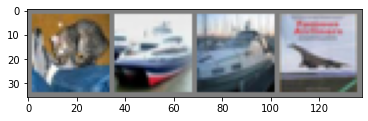

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane


In [16]:
dataiter = iter(testloader) # Iterator over the testing set
images, labels = next(dataiter)

# Printing the ground truth images and labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Printing the labels the network assigned to the input images
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

To understand which classes of images our classifier struggles the most with and which classes of images it is more accurate on, let's try printing the accuracy of the network on both the whole dataset and on each class of images:

In [17]:
# Calculating the accuracy of the network on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data # Getting the test data
        outputs = net(images) # Getting the network output
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Calculating the accuracy of the network on each class of images
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data # Getting the test data
        outputs = net(images) # Getting the network output
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 68 %
Accuracy of   car : 87 %
Accuracy of  bird : 38 %
Accuracy of   cat : 35 %
Accuracy of  deer : 55 %
Accuracy of   dog : 58 %
Accuracy of  frog : 60 %
Accuracy of horse : 74 %
Accuracy of  ship : 70 %
Accuracy of truck : 73 %


Notice that each time we'll re-train the neural network we will have different performances and accuracies, this because of the stochastic nature of the training phase.